# Hourly demand
Base demand data is currently restricted to 2012, although it is possible for a user to load 2011 data from IPM that is stored in the PUDL database. The 2012 demand data are aligned with renewables generation data provided with PowerGenome, and with electrification profiles included in the [NREL Electrification Futures Study](https://data.nrel.gov/submissions/126). Although 2012 is a leap year with 8784 hours, PowerGenome removes February 29 by default. If this is a problem, [file an issue](https://github.com/gschivley/PowerGenome/issues) on GitHub and I'll look into making it optional.

**NOTE:** All 2012 load profiles have been compiled using FERC 714 data. Hourly demand from each entity is mapped to the counties that they serve (using EIA 861), and re-apportioned to IPM regions based on population. Anomalies were detected and fixed using code developed by [Tyler Ruggles and David Farnham](https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Code). Loads in each region are then adjusted based on the ratio of FERC load in 2011 to IPM load in 2011. **Finally, all load has been shifted to UTC time, which matches generation profiles linked to in the README.** The regions `WECC_SNV`, `MIS_MO`, and `PJM_SMAC` have total/peak load that is more than 30% off from IPM 2011 data. Future versions of the data may use different allocation methods that also account for large industrial/commercial loads. I'll post any updated on the [PowerGenome groups.io](https://groups.io/g/powergenome) site.

Hourly demand is one of the few remaining areas of PowerGenome where users may need to supply data, although this is limited to hourly profiles of demand response resources (possibly from the NREL data) and hourly profiles/capacity of distributed generation. Rooftop solar PV profiles can be obtained from sources such as NREL or [Renewables.ninja](https://www.renewables.ninja/).

Examples of user-supplied data - including load profiles - are included in `example_system/extra_inputs`. The corresponding parameters are
- `distributed_gen_profiles_fn`
- `demand_response_fn`
- `regional_load_fn` 

Note that if external load profiles include electrification/demand reponse load you should set the parameter `regional_load_includes_demand_response` to `True`. In this case the demand response profiles are used to calculate capacity of the resource in each planning year (in the new generators data), but they are not added to the load profiles.

Distributed generation profiles, which are normalized from 0-1, can be scaled as either a fraction of total load (in cases where DG is part of an RPS set-aside) or according to a total capacity (where capacity projections are available). This is done using the parameters
- `distributed_gen_method` (key: region name, value: `capacity` or `fraction_load`)
- `distributed_gen_values` (nested dictionary for each planning year)
- `avg_distribution_loss` (simplified as a single value for all regions, used to scale up DG when subtracting from total load)

Final load profiles are calculated as follows:
1. Read hourly load data from either the PUDL sqlite database or the user-supplied CSV file.
2. If read from sqlite:  
    a. Combine IPM regions into model regions using the `region_aggregations` parameter.  
    b. Scale up hourly load from base year (2012) to 2018 using historical demand from EIA AEO electricity market module (EMM) regions (AEO 2014 and AEO 2019, IPM regions mapped to EMM regions in the parameter `historical_load_region_maps`). Scale from 2019 to the model year using AEO 2020. EIA changed AEO EMM regions in 2020, and IPM regions are mapped to the new EMM regions in the parameter `future_load_region_map`.   
3. If loaded from sqlite, or user-supplied data and values do not include demand response, add DR profiles to load profiles (if hourly DR demand is supplied by the user).
4. If distributed generation curves and scaling method/values are provided, subtract DG from load curves.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
from powergenome.load_profiles import (
    make_load_curves, 
    add_load_growth, 
    make_final_load_curves, 
    make_distributed_gen_profiles,
)
from powergenome.external_data import make_demand_response_profiles
from powergenome.generators import GeneratorClusters
from powergenome.util import (
    build_scenario_settings,
    init_pudl_connection,
    load_settings,
    reverse_dict_of_lists,
    remove_feb_29,
    check_settings
)

## Import settings
This assumes that the settings file is set up for multiple scenarios/planning periods. If you are using a settings file with only a single scenario/planning period, remove or comment out the line with `build_scenario_settings`.

In [3]:
cwd = Path.cwd()

settings_path = (
    cwd.parent / "example_system" / "test_settings.yml"
)
settings = load_settings(settings_path)
settings["input_folder"] = settings_path.parent / settings["input_folder"]
scenario_definitions = pd.read_csv(
    settings["input_folder"] / settings["scenario_definitions_fn"]
)
scenario_settings = build_scenario_settings(settings, scenario_definitions)

pudl_engine, pudl_out, pg_engine = init_pudl_connection(
    freq="AS",
    start_year=min(settings.get("data_years")),
    end_year=max(settings.get("data_years")),
)

check_settings(settings, pg_engine)

## Build load curves
If you just want the final load curves that include any demand response/distributed generation, the function `make_final_load_curves` is all you need.

In [4]:
load_curves = make_final_load_curves(pg_engine, scenario_settings[2030]["p1"])
load_curves

region,CA_N,CA_S,WECC_AZ
time_index,,,
1,14211,18064,10358
2,13539,17227,10054
3,12836,16394,9670
4,13052,14691,9545
5,12452,14045,9411
...,...,...,...
8756,13983,17833,11038
8757,15896,20164,11764
8758,16058,20372,11449


<AxesSubplot:xlabel='time_index'>

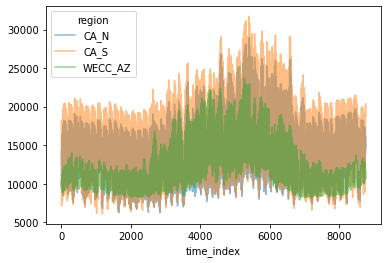

In [5]:
load_curves.plot(alpha=0.5)

## Load curve components

The individual components of a final load curve can also be accessed.

### Scaled 2012 load

In [6]:
scaled_load = make_load_curves(pg_engine, scenario_settings[2030]["p1"])

### Demand response

In [7]:
dr_path = settings["input_folder"] / settings["demand_response_fn"]
dr_types = settings["demand_response_resources"][scenario_settings[2030]["p1"]["model_year"]].keys()
dr_profiles = make_demand_response_profiles(dr_path, list(dr_types)[0], scenario_settings[2030]["p1"])
dr_profiles

,CA_N,CA_S
0,52.8,68.1
1,49.3,63.6
2,19.0,24.5
3,14.4,18.6
4,9.1,11.8
...,...,...
8755,367.7,474.1
8756,357.6,461.0
8757,302.8,390.3
8758,52.8,68.1


### Distributed generation

In [8]:
dg_profiles = make_distributed_gen_profiles(pg_engine, scenario_settings[2030]["p1"])
dg_profiles

,CA_N,CA_S
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
8755,0.0,0.0
8756,0.0,0.0
8757,0.0,0.0
8758,0.0,0.0
